In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import glob
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Data Loading and Exploration

In [2]:
# Define the data directory
data_dir = './data/'

# Check available files
file_list = glob.glob(os.path.join(data_dir, '*.dat'))
print(f"Found {len(file_list)} data files")

# Create a mapping for activity IDs to names
activity_map = {
    0: 'Other (transient)',
    1: 'Lying',
    2: 'Sitting',
    3: 'Standing',
    4: 'Walking',
    5: 'Running',
    6: 'Cycling',
    7: 'Nordic walking',
    9: 'Watching TV',
    10: 'Computer work',
    11: 'Car driving',
    12: 'Ascending stairs',
    13: 'Descending stairs',
    16: 'Vacuum cleaning',
    17: 'Ironing',
    18: 'Folding laundry',
    19: 'House cleaning',
    20: 'Playing soccer',
    24: 'Rope jumping'
}

# Subject demographic data
subject_info = {
    101: {'sex': 'Male', 'age': 27, 'height': 182, 'weight': 83, 'resting_hr': 75, 'max_hr': 193, 'dominant_hand': 'Right'},
    102: {'sex': 'Female', 'age': 25, 'height': 169, 'weight': 78, 'resting_hr': 74, 'max_hr': 195, 'dominant_hand': 'Right'},
    103: {'sex': 'Male', 'age': 31, 'height': 187, 'weight': 92, 'resting_hr': 68, 'max_hr': 189, 'dominant_hand': 'Right'},
    104: {'sex': 'Male', 'age': 24, 'height': 194, 'weight': 95, 'resting_hr': 58, 'max_hr': 196, 'dominant_hand': 'Right'},
    105: {'sex': 'Male', 'age': 26, 'height': 180, 'weight': 73, 'resting_hr': 70, 'max_hr': 194, 'dominant_hand': 'Right'},
    106: {'sex': 'Male', 'age': 26, 'height': 183, 'weight': 69, 'resting_hr': 60, 'max_hr': 194, 'dominant_hand': 'Right'},
    107: {'sex': 'Male', 'age': 23, 'height': 173, 'weight': 86, 'resting_hr': 60, 'max_hr': 197, 'dominant_hand': 'Right'},
    108: {'sex': 'Male', 'age': 32, 'height': 179, 'weight': 87, 'resting_hr': 66, 'max_hr': 188, 'dominant_hand': 'Left'},
    109: {'sex': 'Male', 'age': 31, 'height': 168, 'weight': 65, 'resting_hr': 54, 'max_hr': 189, 'dominant_hand': 'Right'}
}

# Define column names based on the dataset description
columns = ['timestamp', 'activity_id']
columns.append('heart_rate')

# IMU columns for each sensor location (hand, chest, ankle)
imu_columns = ['temperature', 
               'acc_x_16g', 'acc_y_16g', 'acc_z_16g',  # ±16g accelerometer
               'acc_x_6g', 'acc_y_6g', 'acc_z_6g',     # ±6g accelerometer
               'gyro_x', 'gyro_y', 'gyro_z',           # gyroscope
               'mag_x', 'mag_y', 'mag_z',              # magnetometer
               'ori_w', 'ori_x', 'ori_y', 'ori_z']     # orientation (invalid)

sensor_locations = ['hand', 'chest', 'ankle']
for location in sensor_locations:
    for i, col in enumerate(imu_columns):
        columns.append(f'{location}_{col}')

print(f"Total columns: {len(columns)}")
print(f"Column names: {columns[:10]}...")  # Show first 10 columns

Found 9 data files
Total columns: 54
Column names: ['timestamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_acc_x_16g', 'hand_acc_y_16g', 'hand_acc_z_16g', 'hand_acc_x_6g', 'hand_acc_y_6g', 'hand_acc_z_6g']...


# Step 2: Load and Combine All Data

In [3]:
def load_and_combine_data(file_list):
    """Load all data files and combine them into a single DataFrame"""
    all_data = []
    
    for file_path in file_list:
        # Extract subject ID from filename (assuming format like subject101_session1.dat)
        filename = os.path.basename(file_path)
        # Try to extract subject ID - adjust this based on actual filenames
        try:
            subject_id = int(''.join(filter(str.isdigit, filename.split('_')[0])))
        except:
            subject_id = int(''.join(filter(str.isdigit, filename))[:3])
        
        # Load the data
        df = pd.read_csv(file_path, sep='\s+', header=None, names=columns, low_memory=False)
        
        # Add subject ID
        df['subject_id'] = subject_id
        
        # Add demographic information
        if subject_id in subject_info:
            for key, value in subject_info[subject_id].items():
                df[key] = value
        
        all_data.append(df)
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    
    return combined_df

# Load all data
print("Loading data...")
df = load_and_combine_data(file_list)
print(f"Loaded {len(df)} rows of data")
print(f"Columns: {df.columns.tolist()}")

Loading data...
Loaded 2872533 rows of data
Columns: ['timestamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_acc_x_16g', 'hand_acc_y_16g', 'hand_acc_z_16g', 'hand_acc_x_6g', 'hand_acc_y_6g', 'hand_acc_z_6g', 'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z', 'hand_mag_x', 'hand_mag_y', 'hand_mag_z', 'hand_ori_w', 'hand_ori_x', 'hand_ori_y', 'hand_ori_z', 'chest_temperature', 'chest_acc_x_16g', 'chest_acc_y_16g', 'chest_acc_z_16g', 'chest_acc_x_6g', 'chest_acc_y_6g', 'chest_acc_z_6g', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'chest_ori_w', 'chest_ori_x', 'chest_ori_y', 'chest_ori_z', 'ankle_temperature', 'ankle_acc_x_16g', 'ankle_acc_y_16g', 'ankle_acc_z_16g', 'ankle_acc_x_6g', 'ankle_acc_y_6g', 'ankle_acc_z_6g', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z', 'ankle_ori_w', 'ankle_ori_x', 'ankle_ori_y', 'ankle_ori_z', 'subject_id', 'sex', 'age', 'height', 'weight', 'resting_hr', 'max

# Step 3: Data Exploration and Visualization


=== Data Exploration ===
Data shape: (2872533, 62)
Missing values:
heart_rate          2610265
hand_temperature      13141
hand_acc_x_16g        13141
hand_acc_y_16g        13141
hand_acc_x_6g         13141
hand_acc_z_16g        13141
hand_gyro_x           13141
hand_gyro_y           13141
hand_acc_y_6g         13141
hand_acc_z_6g         13141
dtype: int64

Activity distribution:
  0: Other (transient) - 929661 samples (32.36%)
  1: Lying - 192523 samples (6.70%)
  2: Sitting - 185188 samples (6.45%)
  3: Standing - 189931 samples (6.61%)
  4: Walking - 238761 samples (8.31%)
  5: Running - 98199 samples (3.42%)
  6: Cycling - 164600 samples (5.73%)
  7: Nordic walking - 188107 samples (6.55%)
  12: Ascending stairs - 117216 samples (4.08%)
  13: Descending stairs - 104944 samples (3.65%)
  16: Vacuum cleaning - 175353 samples (6.10%)
  17: Ironing - 238690 samples (8.31%)
  24: Rope jumping - 49360 samples (1.72%)


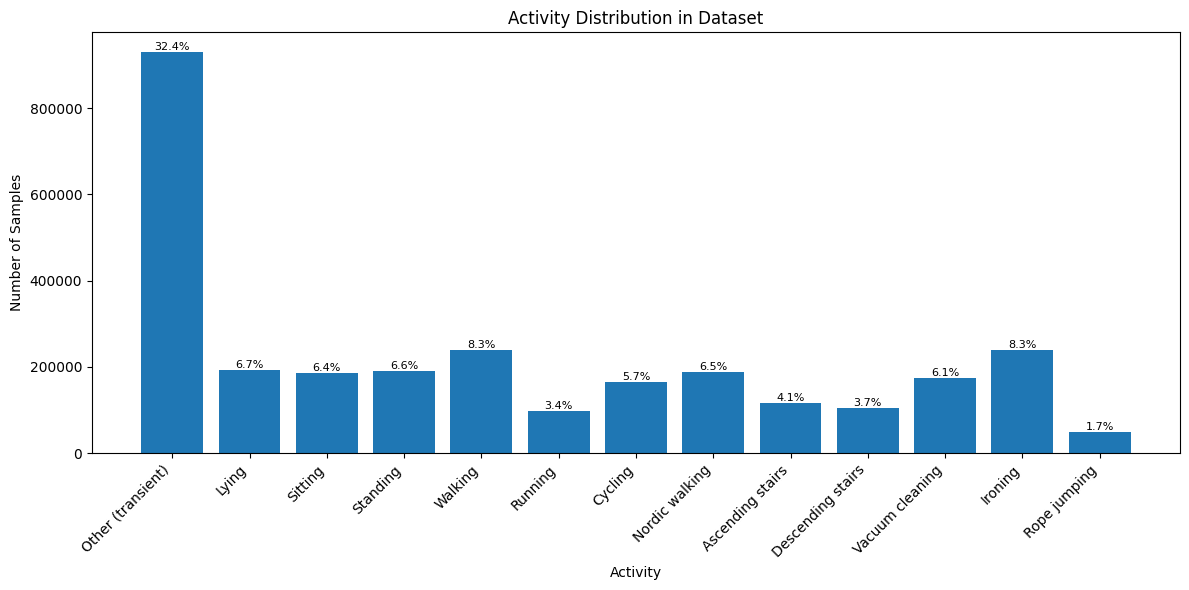


Subject distribution:
  Subject 101: 376417 samples (13.10%)
  Subject 102: 447000 samples (15.56%)
  Subject 103: 252833 samples (8.80%)
  Subject 104: 329576 samples (11.47%)
  Subject 105: 374783 samples (13.05%)
  Subject 106: 361817 samples (12.60%)
  Subject 107: 313599 samples (10.92%)
  Subject 108: 408031 samples (14.20%)
  Subject 109: 8477 samples (0.30%)


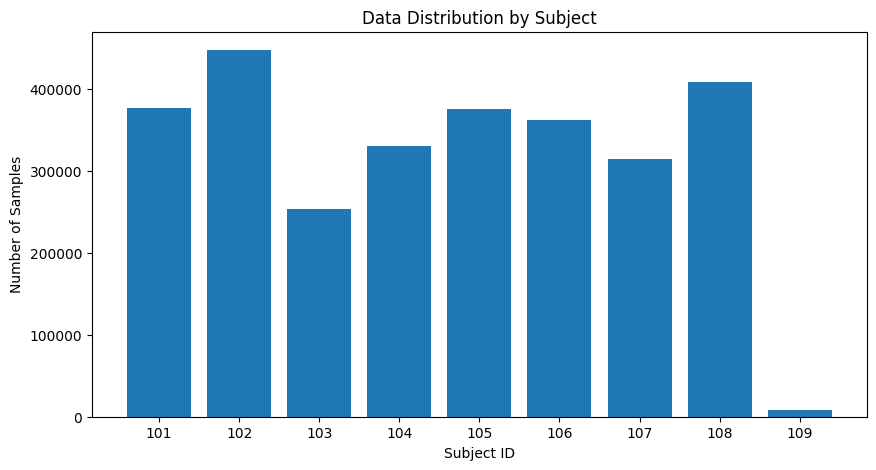

In [4]:
# Basic data exploration
print("\n=== Data Exploration ===")
print(f"Data shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False).head(10)}")

# Activity distribution
activity_counts = df['activity_id'].value_counts().sort_index()
print("\nActivity distribution:")
for activity_id, count in activity_counts.items():
    activity_name = activity_map.get(activity_id, f"Unknown ({activity_id})")
    print(f"  {activity_id}: {activity_name} - {count} samples ({count/len(df)*100:.2f}%)")

# Visualize activity distribution
plt.figure(figsize=(12, 6))
activity_names = [activity_map.get(i, f"ID {i}") for i in activity_counts.index]
bars = plt.bar(activity_names, activity_counts.values)
plt.title('Activity Distribution in Dataset')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    percentage = (height / len(df)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

plt.show()

# Check subject distribution
subject_counts = df['subject_id'].value_counts().sort_index()
print("\nSubject distribution:")
for subject_id, count in subject_counts.items():
    print(f"  Subject {subject_id}: {count} samples ({count/len(df)*100:.2f}%)")

plt.figure(figsize=(10, 5))
plt.bar(subject_counts.index.astype(str), subject_counts.values)
plt.title('Data Distribution by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Number of Samples')
plt.show()

# Step 4: Data Preprocessing

In [5]:
# Filter out transient activities (ID = 0)
print(f"Data shape before filtering transient activities: {df.shape}")
df = df[df['activity_id'] != 0]
print(f"Data shape after filtering transient activities: {df.shape}")

# Check for activities with very few samples
min_samples = 100  # Minimum samples per class
activity_sample_counts = df['activity_id'].value_counts()
activities_to_keep = activity_sample_counts[activity_sample_counts >= min_samples].index
df = df[df['activity_id'].isin(activities_to_keep)]

print(f"\nActivities kept (with at least {min_samples} samples):")
for activity_id in sorted(activities_to_keep):
    count = activity_sample_counts[activity_id]
    activity_name = activity_map.get(activity_id, f"Unknown ({activity_id})")
    print(f"  {activity_id}: {activity_name} - {count} samples")

# Handle missing values - impute with median for numerical columns
print(f"\nMissing values before imputation: {df.isnull().sum().sum()}")

# Separate features and target
X = df.drop(['activity_id', 'timestamp', 'subject_id', 'sex', 'dominant_hand'], axis=1, errors='ignore')
y = df['activity_id']

# Convert categorical columns to numeric
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print(f"Missing values after imputation: {pd.DataFrame(X_imputed, columns=X.columns).isnull().sum().sum()}")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a mapping for encoded labels back to activity names
encoded_activity_map = {}
for original_id, encoded_id in zip(y.unique(), np.unique(y_encoded)):
    activity_name = activity_map.get(original_id, f"Unknown ({original_id})")
    encoded_activity_map[encoded_id] = activity_name

print(f"\nEncoded activity mapping:")
for encoded_id in sorted(encoded_activity_map.keys()):
    print(f"  {encoded_id}: {encoded_activity_map[encoded_id]}")

Data shape before filtering transient activities: (2872533, 62)
Data shape after filtering transient activities: (1942872, 62)

Activities kept (with at least 100 samples):
  1: Lying - 192523 samples
  2: Sitting - 185188 samples
  3: Standing - 189931 samples
  4: Walking - 238761 samples
  5: Running - 98199 samples
  6: Cycling - 164600 samples
  7: Nordic walking - 188107 samples
  12: Ascending stairs - 117216 samples
  13: Descending stairs - 104944 samples
  16: Vacuum cleaning - 175353 samples
  17: Ironing - 238690 samples
  24: Rope jumping - 49360 samples

Missing values before imputation: 2140331
Missing values after imputation: 0

Encoded activity mapping:
  0: Lying
  1: Sitting
  2: Standing
  3: Ironing
  4: Vacuum cleaning
  5: Ascending stairs
  6: Descending stairs
  7: Walking
  8: Nordic walking
  9: Cycling
  10: Running
  11: Rope jumping


# Step 5: Train-Test Split by Subject (Subject-wise Split)

In [6]:
# Step 5: Train-Test Split by Subject (Subject-wise Split)

# Get unique subjects
unique_subjects = df['subject_id'].unique()
print(f"Unique subjects: {unique_subjects}")

# Split subjects into train and test (80-20 split)
# Since we have 9 subjects, let's do 7 train and 2 test
np.random.seed(42)
train_subjects = np.random.choice(unique_subjects, size=7, replace=False)
test_subjects = np.array([s for s in unique_subjects if s not in train_subjects])

print(f"Train subjects: {train_subjects}")
print(f"Test subjects: {test_subjects}")

# Create train and test masks from the original df
train_mask = df['subject_id'].isin(train_subjects)
test_mask = df['subject_id'].isin(test_subjects)

# BEFORE preprocessing, split the data
df_train_raw = df[train_mask].copy()
df_test_raw = df[test_mask].copy()

print(f"\nTraining subjects data shape: {df_train_raw.shape}")
print(f"Test subjects data shape: {df_test_raw.shape}")

# Now preprocess training and test data separately
def preprocess_data(df_subset):
    """Preprocess a subset of data"""
    # Filter out transient activities (ID = 0)
    df_clean = df_subset[df_subset['activity_id'] != 0].copy()
    
    # Check for activities with very few samples
    min_samples = 100
    activity_sample_counts = df_clean['activity_id'].value_counts()
    activities_to_keep = activity_sample_counts[activity_sample_counts >= min_samples].index
    df_clean = df_clean[df_clean['activity_id'].isin(activities_to_keep)]
    
    # Separate features and target
    X = df_clean.drop(['activity_id', 'timestamp', 'subject_id', 'sex', 'dominant_hand'], axis=1, errors='ignore')
    y = df_clean['activity_id']
    
    # Convert categorical columns to numeric
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
    
    return X, y

# Preprocess training and test data
print("\nPreprocessing training data...")
X_train_raw, y_train_raw = preprocess_data(df_train_raw)
print(f"Training data shape after preprocessing: {X_train_raw.shape}")

print("\nPreprocessing test data...")
X_test_raw, y_test_raw = preprocess_data(df_test_raw)
print(f"Test data shape after preprocessing: {X_test_raw.shape}")

# Encode target labels using LabelEncoder fitted on training data
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# Create a mapping for encoded labels
encoded_activity_map = {}
for original_id, encoded_id in zip(np.unique(y_train_raw), np.unique(y_train)):
    activity_name = activity_map.get(original_id, f"Unknown ({original_id})")
    encoded_activity_map[encoded_id] = activity_name

print(f"\nNumber of classes in training: {len(np.unique(y_train))}")
print(f"Number of classes in test: {len(np.unique(y_test))}")

# Further split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\nFinal splits:")
print(f"  Training set: {X_train.shape}")
print(f"  Validation set: {X_val.shape}")
print(f"  Test set: {X_test_raw.shape}")

# Display class distributions
print("\nTraining set class distribution:")
train_counts = Counter(y_train)
for class_id, count in sorted(train_counts.items()):
    activity_name = encoded_activity_map.get(class_id, f"Class {class_id}")
    percentage = count / len(y_train) * 100
    print(f"  {activity_name}: {count} samples ({percentage:.2f}%)")

print("\nTest set class distribution:")
test_counts = Counter(y_test)
for class_id, count in sorted(test_counts.items()):
    activity_name = encoded_activity_map.get(class_id, f"Class {class_id}")
    percentage = count / len(y_test) * 100
    print(f"  {activity_name}: {count} samples ({percentage:.2f}%)")

Unique subjects: [101 102 103 104 105 106 107 108 109]
Train subjects: [108 102 106 101 109 103 105]
Test subjects: [104 107]

Training subjects data shape: (1478675, 62)
Test subjects data shape: (464197, 62)

Preprocessing training data...
Training data shape after preprocessing: (1478675, 57)

Preprocessing test data...
Test data shape after preprocessing: (464197, 57)

Number of classes in training: 12
Number of classes in test: 11

Final splits:
  Training set: (1182940, 57)
  Validation set: (295735, 57)
  Test set: (464197, 57)

Training set class distribution:
  Lying: 115092 samples (9.73%)
  Sitting: 117931 samples (9.97%)
  Standing: 111579 samples (9.43%)
  Walking: 138487 samples (11.71%)
  Running: 75605 samples (6.39%)
  Cycling: 95377 samples (8.06%)
  Nordic walking: 105479 samples (8.92%)
  Ascending stairs: 66301 samples (5.60%)
  Descending stairs: 63233 samples (5.35%)
  Vacuum cleaning: 107011 samples (9.05%)
  Ironing: 147357 samples (12.46%)
  Rope jumping: 3948

# Step 6: Feature Scaling

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_raw)

print(f"Training set after scaling: {X_train_scaled.shape}")
print(f"Mean of training features: {X_train_scaled.mean():.2f}")
print(f"Std of training features: {X_train_scaled.std():.2f}")

Training set after scaling: (1182940, 57)
Mean of training features: -0.00
Std of training features: 1.00


# Step 7: Feature Engineering - Extract Basic Statistical Features

In [8]:
# Since we're working with time-series data, let's create some window-based features
def extract_basic_features(X_data, window_size=50):
    """Extract simple statistical features from time-series windows"""
    n_samples, n_features = X_data.shape
    n_windows = n_samples // window_size
    
    # We'll skip this for initial implementation to keep it simple
    # In a real implementation, you would extract features like:
    # mean, std, min, max, median for each window
    return X_data

# For simplicity, we'll use the raw features for now
# In a more advanced implementation, you would extract window-based features
print("Using raw sensor readings as features for initial implementation")

Using raw sensor readings as features for initial implementation


# Step 8: Train Random Forest Model

In [9]:
# Initialize and train Random Forest model
print("\n=== Training Random Forest Model ===")

# Start with a reasonable set of parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1,
    random_state=42
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

print("Model training completed!")
print(f"Number of features used: {rf_model.n_features_in_}")
print(f"Number of trees: {rf_model.n_estimators}")


=== Training Random Forest Model ===
Model training completed!
Number of features used: 57
Number of trees: 100


# Step 9: Model Evaluation

In [10]:
# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_val_pred = rf_model.predict(X_val_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name="Set"):
    """Calculate and display classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{set_name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

# Calculate metrics for all sets
train_acc, train_prec, train_rec, train_f1 = calculate_metrics(y_train, y_train_pred, "Training")
val_acc, val_prec, val_rec, val_f1 = calculate_metrics(y_val, y_val_pred, "Validation")
test_acc, test_prec, test_rec, test_f1 = calculate_metrics(y_test, y_test_pred, "Test")

# Calculate final score as per project requirements
final_score = test_acc * test_f1
print(f"\n=== Final Score (Accuracy × F1-Score) ===")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Final Score: {final_score:.4f}")


Training Metrics:
  Accuracy: 0.9999
  Precision: 0.9999
  Recall: 0.9999
  F1-Score: 0.9999

Validation Metrics:
  Accuracy: 0.9997
  Precision: 0.9997
  Recall: 0.9997
  F1-Score: 0.9997

Test Metrics:
  Accuracy: 0.7629
  Precision: 0.7817
  Recall: 0.7629
  F1-Score: 0.7550

=== Final Score (Accuracy × F1-Score) ===
Test Accuracy: 0.7629
Test F1-Score: 0.7550
Final Score: 0.5760


# Step 10: Detailed Analysis

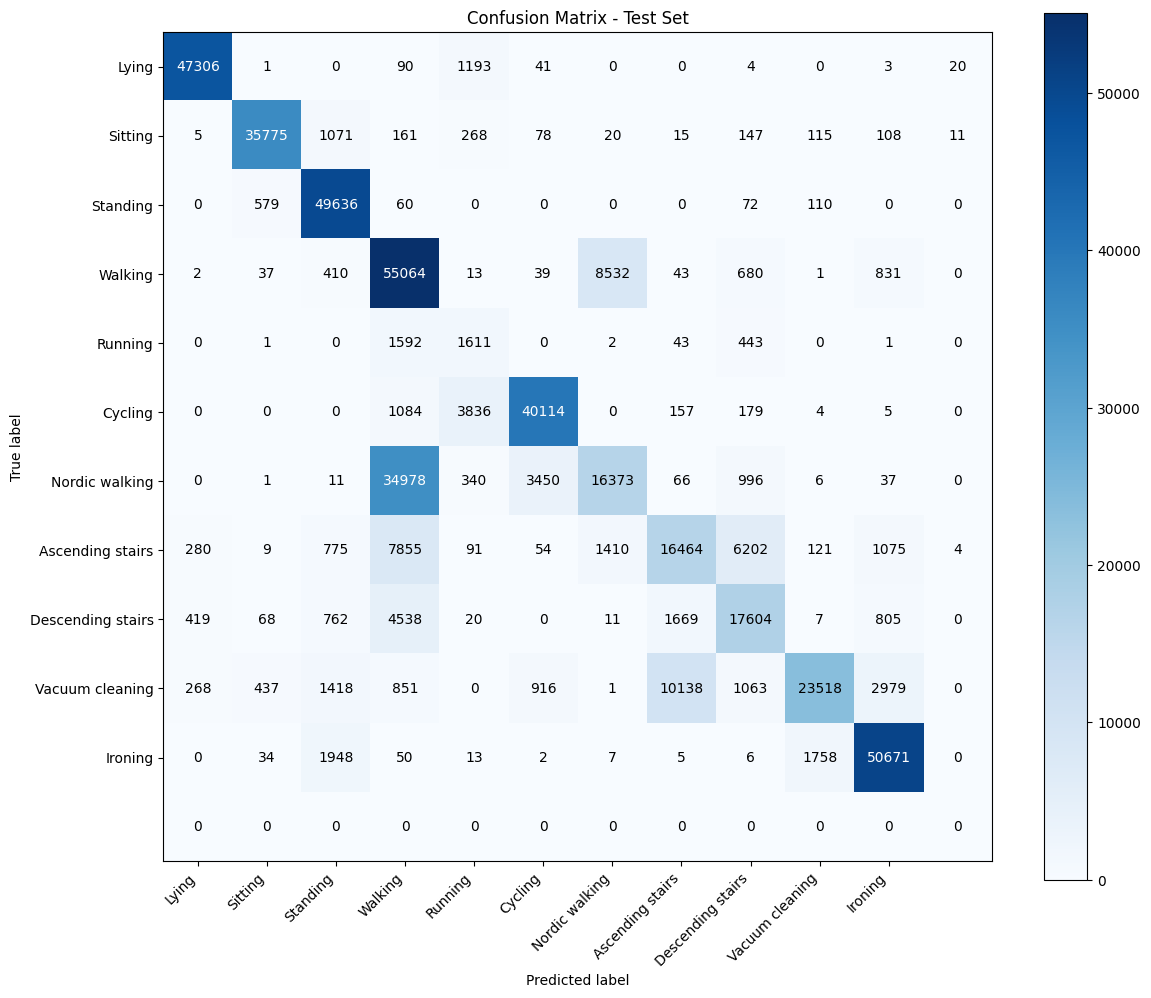

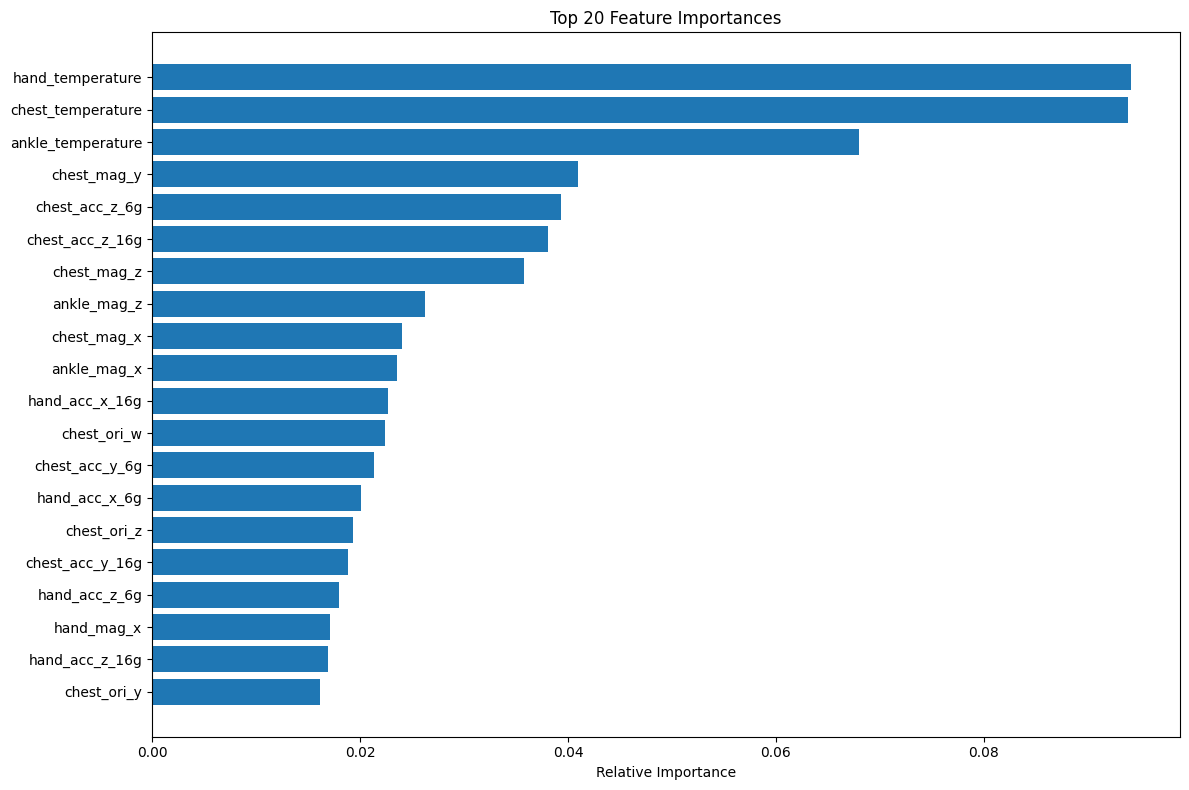


Top 10 Most Important Features:
  hand_temperature: 0.0942
  chest_temperature: 0.0939
  ankle_temperature: 0.0680
  chest_mag_y: 0.0409
  chest_acc_z_6g: 0.0393
  chest_acc_z_16g: 0.0381
  chest_mag_z: 0.0358
  ankle_mag_z: 0.0262
  chest_mag_x: 0.0241
  ankle_mag_x: 0.0236


In [11]:
# Generate confusion matrix for test set
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_test_pred)

# Get class labels
class_labels = [encoded_activity_map[i] for i in sorted(np.unique(y_test))]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45, ha='right')
plt.yticks(tick_marks, class_labels)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Feature importance analysis
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Get top 20 most important features
indices = np.argsort(feature_importance)[::-1][:20]

plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i in indices[:10]:
    print(f"  {feature_names[i]}: {feature_importance[i]:.4f}")

# Step 11: Handle Class Imbalance Analysis


=== Class Distribution Analysis ===
Training set class distribution:
  Lying: 115092 samples (9.73%)
  Sitting: 117931 samples (9.97%)
  Standing: 111579 samples (9.43%)
  Walking: 138487 samples (11.71%)
  Running: 75605 samples (6.39%)
  Cycling: 95377 samples (8.06%)
  Nordic walking: 105479 samples (8.92%)
  Ascending stairs: 66301 samples (5.60%)
  Descending stairs: 63233 samples (5.35%)
  Vacuum cleaning: 107011 samples (9.05%)
  Ironing: 147357 samples (12.46%)
  Rope jumping: 39488 samples (3.34%)

Test set class distribution:
  Lying: 48658 samples (10.48%)
  Sitting: 37774 samples (8.14%)
  Standing: 50457 samples (10.87%)
  Walking: 65652 samples (14.14%)
  Running: 3693 samples (0.80%)
  Cycling: 45379 samples (9.78%)
  Nordic walking: 56258 samples (12.12%)
  Ascending stairs: 34340 samples (7.40%)
  Descending stairs: 25903 samples (5.58%)
  Vacuum cleaning: 41589 samples (8.96%)
  Ironing: 54494 samples (11.74%)

=== Per-Class Metrics on Test Set ===
All classes in dat

<Figure size 1400x800 with 0 Axes>

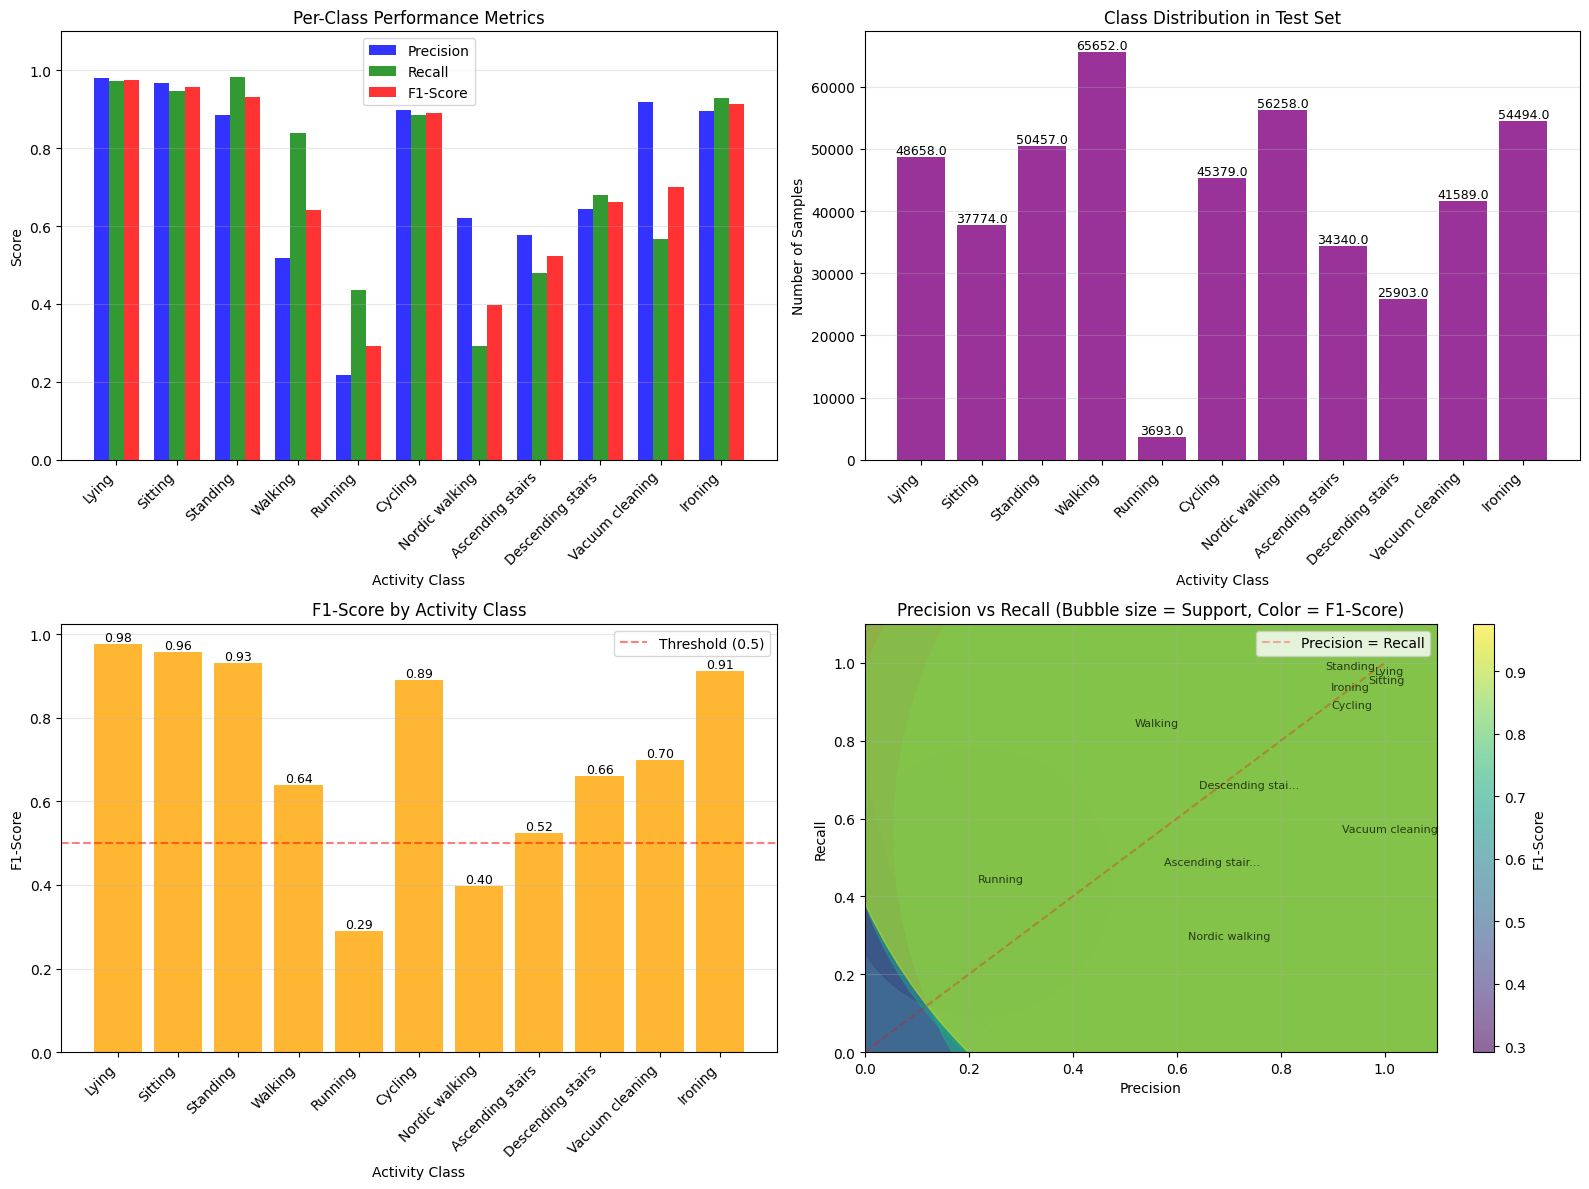


=== Classes with F1-Score < 0.5 ===
These activities might need more data or feature engineering:
  Running: F1-Score = 0.291, Support = 3693.0
  Nordic walking: F1-Score = 0.396, Support = 56258.0

=== Classes with Best Performance ===
  Lying: F1-Score = 0.976, Precision = 0.980, Recall = 0.972
  Sitting: F1-Score = 0.958, Precision = 0.968, Recall = 0.947
  Standing: F1-Score = 0.932, Precision = 0.886, Recall = 0.984


In [ ]:
# Step 12: Handle Class Imbalance Analysis (Fixed Version)
print("\n=== Class Distribution Analysis ===")

train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

print("Training set class distribution:")
for class_id, count in sorted(train_class_counts.items()):
    percentage = count / len(y_train) * 100
    activity_name = encoded_activity_map.get(class_id, f"Class {class_id}")
    print(f"  {activity_name}: {count} samples ({percentage:.2f}%)")

print("\nTest set class distribution:")
for class_id, count in sorted(test_class_counts.items()):
    percentage = count / len(y_test) * 100
    activity_name = encoded_activity_map.get(class_id, f"Class {class_id}")
    print(f"  {activity_name}: {count} samples ({percentage:.2f}%)")

# Calculate per-class metrics on test set
print("\n=== Per-Class Metrics on Test Set ===")

# Get all unique classes that appear in either train or test
all_classes = sorted(set(np.unique(y_train)) | set(np.unique(y_test)))
print(f"All classes in data: {all_classes}")

# Get target names for the classes that actually exist in y_test
test_classes = sorted(np.unique(y_test))
target_names = [encoded_activity_map[i] for i in test_classes]

print(f"Classes in test set: {test_classes}")
print(f"Target names: {target_names}")

# For a more comprehensive report including all possible classes
print("\n=== Comprehensive Per-Class Metrics (including missing classes) ===")
all_target_names = [encoded_activity_map.get(i, f"Class {i}") for i in all_classes]

# We need to ensure all classes are included in the report
# Get the labels parameter to include all classes
report_dict = classification_report(y_test, y_test_pred, 
                                    labels=all_classes,
                                    target_names=all_target_names,
                                    zero_division=0,
                                    output_dict=True)

# Convert to DataFrame for better display
report_df = pd.DataFrame(report_dict).transpose()
print(report_df.to_string())

# Visualize per-class metrics
plt.figure(figsize=(14, 8))

# Get metrics for classes that appear in test set
test_report_dict = classification_report(y_test, y_test_pred, 
                                        labels=test_classes,
                                        target_names=target_names,
                                        zero_division=0,
                                        output_dict=True)

# Extract metrics
metrics_data = []
for class_name in target_names:
    if class_name in test_report_dict:
        metrics_data.append({
            'Class': class_name,
            'Precision': test_report_dict[class_name]['precision'],
            'Recall': test_report_dict[class_name]['recall'],
            'F1-Score': test_report_dict[class_name]['f1-score'],
            'Support': test_report_dict[class_name]['support']
        })

metrics_df = pd.DataFrame(metrics_data)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Precision, Recall, F1-Score bar chart
x = np.arange(len(target_names))
width = 0.25
axes[0, 0].bar(x - width, metrics_df['Precision'], width, label='Precision', alpha=0.8, color='blue')
axes[0, 0].bar(x, metrics_df['Recall'], width, label='Recall', alpha=0.8, color='green')
axes[0, 0].bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8, color='red')
axes[0, 0].set_xlabel('Activity Class')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Per-Class Performance Metrics')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(target_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])

# 2. Support (number of samples) bar chart
axes[0, 1].bar(target_names, metrics_df['Support'], alpha=0.8, color='purple')
axes[0, 1].set_xlabel('Activity Class')
axes[0, 1].set_ylabel('Number of Samples')
axes[0, 1].set_title('Class Distribution in Test Set')
axes[0, 1].set_xticklabels(target_names, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, v in enumerate(metrics_df['Support']):
    axes[0, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=9)

# 3. F1-Score distribution
axes[1, 0].bar(target_names, metrics_df['F1-Score'], alpha=0.8, color='orange')
axes[1, 0].set_xlabel('Activity Class')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score by Activity Class')
axes[1, 0].set_xticklabels(target_names, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Threshold (0.5)')
axes[1, 0].legend()

# Add value labels on top of bars
for i, v in enumerate(metrics_df['F1-Score']):
    axes[1, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Precision-Recall scatter plot
scatter = axes[1, 1].scatter(metrics_df['Precision'], metrics_df['Recall'], 
                             s=metrics_df['Support']*10, alpha=0.6, c=metrics_df['F1-Score'], 
                             cmap='viridis')

# Add class labels to points
for i, txt in enumerate(target_names):
    axes[1, 1].annotate(txt[:15] + '...' if len(txt) > 15 else txt, 
                       (metrics_df['Precision'][i], metrics_df['Recall'][i]),
                       fontsize=8, alpha=0.7)

axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Precision vs Recall (Bubble size = Support, Color = F1-Score)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1.1])
axes[1, 1].set_ylim([0, 1.1])

# Add diagonal line for reference
axes[1, 1].plot([0, 1], [0, 1], 'r--', alpha=0.3, label='Precision = Recall')

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('F1-Score')

axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary of poorly performing classes
print("\n=== Classes with F1-Score < 0.5 ===")
poor_performers = metrics_df[metrics_df['F1-Score'] < 0.5]
if len(poor_performers) > 0:
    print("These activities might need more data or feature engineering:")
    for _, row in poor_performers.iterrows():
        print(f"  {row['Class']}: F1-Score = {row['F1-Score']:.3f}, Support = {row['Support']}")
else:
    print("All classes have F1-Score >= 0.5!")

print("\n=== Classes with Best Performance ===")
best_performers = metrics_df.nlargest(3, 'F1-Score')
for _, row in best_performers.iterrows():
    print(f"  {row['Class']}: F1-Score = {row['F1-Score']:.3f}, Precision = {row['Precision']:.3f}, Recall = {row['Recall']:.3f}")

# Step 12: Model Optimization Suggestions

In [16]:
# Hyperparameter tuning suggestions
print("\n=== Model Optimization Suggestions ===")
print("For improved performance, consider:")
print("1. Hyperparameter tuning with GridSearchCV or RandomSearchCV")
print("2. Feature engineering with time-series windows")
print("3. Using SMOTE or other oversampling techniques for rare classes")
print("4. Trying different class weighting strategies")
print("5. Ensemble methods with different classifiers")
print("6. Feature selection to reduce noise")

# Suggested hyperparameter grid for tuning
suggested_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print(f"\nSuggested parameter grid: {suggested_params}")


=== Model Optimization Suggestions ===
For improved performance, consider:
1. Hyperparameter tuning with GridSearchCV or RandomSearchCV
2. Feature engineering with time-series windows
3. Using SMOTE or other oversampling techniques for rare classes
4. Trying different class weighting strategies
5. Ensemble methods with different classifiers
6. Feature selection to reduce noise

Suggested parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None]}


# Step 13: Save Model and Results

In [17]:
import joblib
import json
from datetime import datetime

# Create results directory
results_dir = './results/'
os.makedirs(results_dir, exist_ok=True)

# Save the model
model_path = os.path.join(results_dir, 'random_forest_model.pkl')
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler
scaler_path = os.path.join(results_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label encoder
encoder_path = os.path.join(results_dir, 'label_encoder.pkl')
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder saved to {encoder_path}")

# Save results to a JSON file
results = {
    'timestamp': datetime.now().isoformat(),
    'model_type': 'RandomForest',
    'hyperparameters': {
        'n_estimators': rf_model.n_estimators,
        'max_depth': rf_model.max_depth,
        'class_weight': 'balanced'
    },
    'metrics': {
        'train_accuracy': float(train_acc),
        'train_f1': float(train_f1),
        'validation_accuracy': float(val_acc),
        'validation_f1': float(val_f1),
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'final_score': float(final_score)
    },
    'data_info': {
        'n_train_samples': len(y_train),
        'n_val_samples': len(y_val),
        'n_test_samples': len(y_test),
        'n_features': X_train.shape[1],
        'n_classes': len(np.unique(y_train))
    }
}

results_path = os.path.join(results_dir, 'model_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {results_path}")

# Print summary
print("\n" + "="*50)
print("PROJECT SUMMARY")
print("="*50)
print(f"Model: Random Forest Classifier")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Final Score (Accuracy × F1): {final_score:.4f}")
print("="*50)

Model saved to ./results/random_forest_model.pkl
Scaler saved to ./results/scaler.pkl
Label encoder saved to ./results/label_encoder.pkl
Results saved to ./results/model_results.json

PROJECT SUMMARY
Model: Random Forest Classifier
Number of classes: 12
Training samples: 1182940
Validation samples: 295735
Test samples: 464197
Test Accuracy: 0.7629
Test F1-Score: 0.7550
Final Score (Accuracy × F1): 0.5760
